# animating a single particle trial
Tim Tyree<br>
6.8.2021

In [1]:
from lib.my_initialization import *
from lib.utils.pbc import *
import shutil

In [2]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
#random number stream A
rs = RandomState(MT19937(SeedSequence(123456789)))
#random number stream B
# rs = RandomState(MT19937(SeedSequence(987654321)))

#get distance metric
distance_L2_pbc=get_distance_L2_pbc(width=1,height=1)
np.random.seed(123456789)

In [3]:
#DONE: plot all particle positions with this ic.  
#DONE: translate monte carlo into python
#DONE: make a movie for simplest case up to time tmax=1
#DONE: repeat with each attractive force between all particles 
#DONE: repeat with explicitely uniform ic.
#DONE: repeat with each attractive force between all particles 

In [4]:
N=16
L=10
x_values=rs.uniform(size=N)*L
y_values=rs.uniform(size=N)*L
t=0

In [5]:
# #explicitely uniform ic.
# uvals=np.linspace(0,L*4/5,4)
# x_values,y_values=np.meshgrid(uvals,uvals)
# x_values=x_values.flatten()+L/10
# y_values=y_values.flatten()+L/10
# #TODO: explicitely enter ^these values in my c simulation and run it

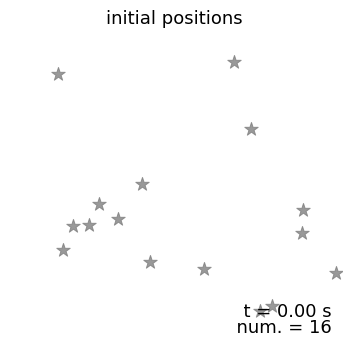

In [6]:
#return a scatter plot that may be saved as png
annotating=True
message='initial positions'
fig=ScatterPlotSnapshot(x_values,y_values,t,width=L,height=L,
                        annotating=annotating,message=message,inch=6)
plt.show()

In [7]:
save_folder=f"{nb_dir}/Figures/mov"
if os.path.exists(save_folder):
    shutil.rmtree(save_folder)
    
os.mkdir(save_folder)
    
frameno=1
save_fn=None
inch=6
annotating=True

# message='without forces'
# force_code=0
# varkappa=0
message='with anti-spring forces'
force_code=1
varkappa=-5
# message='with inverse powerlaw forces'
# force_code=2
# varkappa=5

In [8]:
from numba import jit,njit
@njit
def normalRandom():
    return np.random.normal()

@njit
def uniformRandom():
    return np.random.uniform(0,1)
normalRandom(),uniformRandom()

(0.5223008112208712, 0.3917012992912503)

In [10]:
#define model parameters
r=0.1
D=2
L=10
kappa=1500
# Dt=1e-5;dt=1e-5;tmax=500 #UNCOMMENT_HERE
Dt=1e-5;dt=1e-5;tmax=1 #COMMENT_HERE

#for forces
x0=5
no_repulsion=1
no_attraction=0

#skipping reflect,set_second, and neighbor functionality

#define constants
stepscale=np.sqrt(2*D*Dt)
probreact=kappa*dt
T_net=0;count_net=0
np.random.seed(123456789)
dist_cutoff=1e-2
iter_per_movestep = round(Dt/dt)
impulse_prefactor= varkappa * Dt
save_every=100
step=0

print("running simulation...");
Time=0;t=0
still_running=True;exit_code=-1;T=-9999.
#initialize positions
# #uniform random ic
# x_values=rs.uniform(size=N)*L
# y_values=rs.uniform(size=N)*L
# #explicitely uniform ic
# uvals=np.linspace(0,L,5)
# x_values,y_values=np.meshgrid(uvals,uvals)
# x_values=x_values.flatten()
# y_values=y_values.flatten()

#lower case: world coordinates
#upper case: material coordinates
x=x_values.copy()
y=y_values.copy()
x_old=x_values.copy()
y_old=y_values.copy()
x_new=x_values.copy()
y_new=y_values.copy()
X=x_values.copy()
Y=y_values.copy()
X_old=x_values.copy()
Y_old=y_values.copy()
X_new=x_values.copy()
Y_new=y_values.copy()
zeros=np.zeros_like(x_values)
zerosint=np.zeros_like(x_values).astype('int')
still_running=zerosint==zerosint
# //start set_second kernel
# //end set_second kernel
#TODO: make still_running into still_running_values
while(still_running.any()):
    # //reinitialize_kernel, which copies X,Y_new to X,Y_old
    min_dist_old=zeros+9999999
    i_neighbor=zerosint-1
    X_old=X_new
    Y_old=Y_new
    # //enforce boundary conditions
    for i in range(N):
        x_old[i]=periodic(X_old[i],L);
        y_old[i]=periodic(Y_old[i],L);
    
    t=Time-dt;#//for an insignificant edge case
    Time=Time+Dt;
    
    # reset the net forces
    Fx_net=zeros.copy()
    Fy_net=zeros.copy()
    
    #sum_each_force_kernel
    for i in range(N):
        if(still_running[i]):
            for j in range(i+1,N-1):
                if(still_running[j]):
                    #compute displacement vector with pbc
                    dx = subtract_pbc_1d(x_old[j],x_old[i],L);
                    dy = subtract_pbc_1d(y_old[j],y_old[i],L);

                    dist2=dx*dx+dy*dy;
                    if (dist2<1e-8):
                        dist2=float(1e-8)
                    dist = np.sqrt(dist2)

                    #compute displacement due to drift
                    impulse_factor=0.
                    if (force_code==1):
                      #spring
                      impulse_factor=impulse_prefactor*(dist-x0)/dist;
                    if (force_code==2):
                      #QED2: force ~ inverse power law
                      impulse_factor=impulse_prefactor/dist2;
                    if (force_code==3):
                      #QED3: force ~ inverse square power law
                      impulse_factor=impulse_prefactor/dist2/dist;

                    #set impulse_factor to zero if it is explicitly forbidden by the user input
                    if ((no_attraction==1) & (impulse_factor>0)):
                        impulse_factor=0.
                    if ((no_repulsion==1) & (impulse_factor<0)):
                        impulse_factor=0.

                    #sum Fx_net, Fy_net according to a symplectic (momentum conserving) integrator
                    Fx_net[i]=Fx_net[i]+dx*impulse_factor;
                    Fy_net[i]=Fy_net[i]+dy*impulse_factor;
                    Fx_net[j]=Fx_net[j]-dx*impulse_factor;
                    Fy_net[j]=Fy_net[j]-dy*impulse_factor

    #compute the one_step given the net force, F_net        
    for i in range(N):
        if(still_running[i]):
            dxt=Fx_net[i];
            dyt=Fy_net[i];
            # compute displacement due to gaussian white noise
            dxW=stepscale*normalRandom();
            dyW=stepscale*normalRandom();
            # next spatial position, time integrating by a duration, Dt.
            X_new[i]=X_old[i]+dxW+dxt;
            Y_new[i]=Y_old[i]+dyW+dyt;
            # enforce PBC
            x_new[i]=periodic(X_new[i],L);
            y_new[i]=periodic(Y_new[i],L);        

            
    #interpolation_kernel at short timescale, dt   
    for s in range(iter_per_movestep):
        # compute local time
        t=t+dt;
        frac=(Time-t)/Dt;
        cfrac=1.-frac;
        # kernel_interpolate, which enforces b.c.'s
        for i in range(N):
            if(still_running[i]):
                # linear interpolation
                X[i]=frac*X_old[i]+cfrac*X_new[i];
                Y[i]=frac*Y_old[i]+cfrac*Y_new[i];
                # impose boundary conditions
                # enforce PBC
                x[i]=periodic(X[i],L);
                y[i]=periodic(Y[i],L);

    #reaction_kernel
    for i in range(N):
        if(still_running[i]):
            # // each i,j pair is reached once per call to kernel_measure
            for j in range(i+1,N-1):
                if(still_running[j]):
                    # // compute distance between particles that are still running
                    dist=dist_pbc(x[i],y[i],x[j],y[j],L);
                    in_range=dist<r;
                    # // in_range=true;//uncomment for smeared method
                    # // if two particles are in range
                    if(in_range):
                        # // determine whether those two particles react via the simple method
                        reacts=probreact>uniformRandom();
                        # // determine whether those two particles react via the smeared method
                        # // sig=sigmoid(dist, r, beta);
                        # // reacts=probreact*sig>uniformRandom();
                        if(reacts):
                            T=t;
                            still_running[i]=False;
                            still_running[j]=False;
                            exit_code=1;
             
    if step%save_every==0:
        x_plot=x_new[still_running]
        y_plot=y_new[still_running]
        #save result as png
        SaveScatterPlotSnapshot(x_plot,y_plot,t,width=L,height=L,
                        frameno=frameno,save_folder=save_folder,
                        annotating=annotating,message=message)
        frameno+=1
        
    

    #shut simulation down if it's taking too long...
    if (t>tmax):
        for i in range(N):
            still_running[i]=False;
            exit_code=-99;
    
    step+=1
    #end while running
    
#record this trial
if (exit_code>0):
    if (T>0.):
        T_net=T_net+T;
        count_net=count_net+1;
    
print(f"simulation complete!")

running simulation...
simulation complete!


In [11]:
#loop over particles
#step each particle 
#njit the whole function

In [12]:
still_running

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [13]:
#concatenate the folder of .png files
os.chdir(f'{nb_dir}/../vid/src')
os.system(f'./concat_folder_png.sh');

In [14]:
beep(1)

0